In [1]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import pandas as pd
import argparse
import imutils
import pickle
import cv2
import os
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import urllib.request

Using TensorFlow backend.


In [0]:
data_list = pd.read_excel('Internship_data.xlsx')

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip drive/My\ Drive/final_data-fynd.zip

In [0]:
labels = ['backstrap_BV',
 'backstrap_NBV',
 'buckle_BV',
 'buckle_NBV',
 'hook&look_BV',
 'hook&look_NBV',
 'lace_up_BV',
 'lace_up_NBV',
 'slip_on_BV',
 'slip_on_NBV',
 'zipper_BV',
 'zipper_NBV']


In [5]:
vgg_model = VGG19(weights='imagenet', include_top=False)

W0630 10:36:18.381148 139780937172864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 10:36:18.402068 139780937172864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 10:36:18.405764 139780937172864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 10:36:18.436507 139780937172864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0630 10:36:18.984603 139780937172864 deprecation_wrapp

In [6]:
x = vgg_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

# add output layer
predictions = Dense(12, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=predictions)
model.load_weights('drive/My Drive/fine_tune_shoes_multiclass.best.hdf5')

W0630 10:36:21.114876 139780937172864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
def identify_type_submission(images , labels):
    class_link = pd.DataFrame(columns = ['predicted_class', 'best_view_image'])
    for i in range(0,len(images['class'])):
      best_image_index = 0
      type_score = dict()
      image_list = []
      best_image_link = []
      j = 0
      for view in ['view_1','view_2','view_3','view_4','view_5']:
        try:
          url_response = urllib.request.urlopen(images[view][i])
          img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
          image = cv2.imdecode(img_array, -1)
          image_list.append(image)
          best_image_link.append(images[view][i])
          image = cv2.resize(image, (128,128))
          image = img_to_array(image)
          image = np.expand_dims(image, axis=0)
          proba = model.predict(image)[0]
          idxs = np.argsort(proba)[::-1][:1]
          type_score[j] = {proba[idxs[0]] : labels[idxs[0]]}
          j = j+1
        except:
          continue
          
      best_image = dict()
      count = 0
      for key,i in type_score.items() :
          type_image  = list(i.values())[0]
          score = list(i.keys())[0]
          if type_image.split('_')[1] == 'BV':
              best_image[count] = {score : type_image.split('_')[0]}
          count = count + 1
          
      type_of_footwear = ''
      if len(best_image) == 1:
        for key,value in best_image.items():
              type_of_footwear = list(value.values())[0]
        best_image_index = list(best_image.keys())[0]
        class_link = class_link.append(pd.Series([type_of_footwear, best_image_link[best_image_index]], index=class_link.columns), ignore_index=True)

      if len(best_image) > 1 :
        max_score = 0
        best_image_index = 0
        for key,value in best_image.items():
          if list(value.keys())[0] > max_score:
            max_score = list(value.keys())[0]
            best_image_index = key
            type_of_footwear = list(value.values())[0]
        class_link = class_link.append(pd.Series([type_of_footwear, best_image_link[best_image_index]], index=class_link.columns), ignore_index=True)

      if len(best_image) == 0:
        max_score = 0
        best_image_index = 0
        for key,value in type_score.items():
          if list(value.keys())[0] > max_score:
            max_score = list(value.keys())[0]
            best_image_index = key
            type_of_footwear = list(value.values())[0].split('_')[0]
        class_link = class_link.append(pd.Series([type_of_footwear, best_image_link[best_image_index]], index=class_link.columns), ignore_index=True)
    return class_link

In [21]:
%%time
predicted_data_list = identify_type_submission(data_list, labels)

CPU times: user 1h 15min 16s, sys: 57.8 s, total: 1h 16min 14s
Wall time: 6h 53min 45s


In [0]:
predicted_data_list.loc[predicted_data_list['predicted_class'] == 'slip', 'predicted_class'] = 'slip_on'
predicted_data_list.loc[predicted_data_list['predicted_class'] == 'lace', 'predicted_class'] = 'lace_up'

In [0]:
new_data = pd.concat([data_list, predicted_data_list], axis=1)
new_data.to_excel('Internship_Data-Predicted(Final).xlsx', index=False)

In [38]:
!pip install pandas_ml

     |████████████████████████████████| 102kB 2.7MB/s 


In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

In [57]:
cm = ConfusionMatrix(new_data['class'], new_data['predicted_class'])
cm

Predicted  backstrap  buckle  hook&look  lace_up  slip_on  zipper  __all__
Actual                                                                    
backstrap        241      27         24        0        1      42      335
buckle            15      52         41        1        1      29      139
hook&look          1       0        302        0        0       1      304
lace_up            0       2         39      189       15     208      453
slip_on            1      13         75       15       84     237      425
zipper             5      16         26        1        2     450      500
__all__          263     110        507      206      103     967     2156

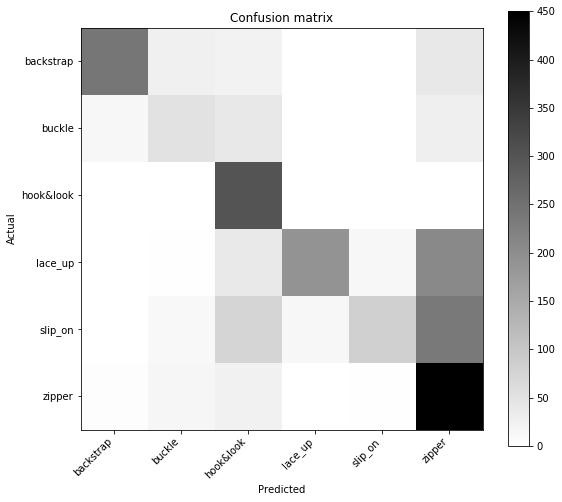

In [58]:
cm.plot()
plt.show()

In [34]:
accuracy_score(new_data['class'], new_data['predicted_class'])

0.6113172541743971